In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import math

In [2]:
# Keras needed modules
models = tf.keras.models
Model = tf.keras.models.Model
layers = tf.keras.layers
initializers = tf.keras.initializers
regularizers = tf.keras.regularizers
optimizers = tf.keras.optimizers
losses = tf.keras.losses
metrics = tf.keras.metrics
preprocessing_image = tf.keras.preprocessing.image
callbacks = tf.keras.callbacks

In [3]:
def residual_block(input_tensor, filters, kernel_size, stage, strides=(1,1), reg=0.0, shortcut='identity'):
    bn_name = 'bn' + str(stage)
    conv_name = 'conv' + str(stage)
    relu_name = 'relu' + str(stage)
    merge_name = 'merge' + str(stage)
    
    ##
    # First convolution layer of the block
    x = layers.Convolution2D(
        filters[0],
        kernel_size[0],
        padding='same',
        strides=strides,
        kernel_regularizer = regularizers.l2(reg),
        use_bias = False,
        name = conv_name + 'a'
        )(input_tensor)
        
    # Batch normalizer layer
    x = layers.BatchNormalization(name = bn_name + 'a')(x)
    
    # Activation layer
    x = layers.Activation('relu', name = relu_name+'a')(x)
    
    # Second convolution layer of the block
    x = layers.Convolution2D(
        filters[1],
        kernel_size[1],
        padding='same',
        kernel_regularizer = regularizers.l2(reg),
        use_bias = False,
        name = conv_name + 'b'
        )(x)
        
    # Batch normalizer layer
    x = layers.BatchNormalization(name = bn_name + 'b')(x)
    
    # Note that all the stages have 3 layers per block except BLOCK 4 stages (the ones with 256 filters size)
    if filters[0] != 256:
        # Activation layer
        x = layers.Activation('relu', name = relu_name+'b')(x)

        # Third convolution layer of the block
        x = layers.Convolution2D(
            filters[2],
            kernel_size[2],
            padding='same',
            kernel_regularizer = regularizers.l2(reg),
            use_bias = False,
            name = conv_name + 'c'
            )(x)

        # Batch normalizer layer
        x = layers.BatchNormalization(name = bn_name + 'c')(x)
        
    # we need to make the shotcut connection
    if shortcut == 'identity':
        x = x # Identity
    else: # Shapes are not the same => conv 1x1
        input_tensor = layers.Convolution2D(
                        filters[-1],    # last layer filter
                        kernel_size[-1],# last layer kernel size
                        strides=strides,
                        padding='same',
                        use_bias = False,
                        )(input_tensor)
    
    # Addition
    x = layers.add([x, input_tensor], name = merge_name)
        
    # Activation layer
    x = layers.Activation('relu', name = relu_name+'c')(x)

    ## We have reached the end of the block
    
    return x

In [4]:
def first_conv_layer(input_tensor, filters=32, kernel_size=(3,3), reg=0.0, conv_name='conv1'):
    # First convolution layer of the block
    x = layers.Convolution2D(
        filters,
        kernel_size,
        kernel_regularizer = regularizers.l2(reg),
        strides = (1,1),
        padding = 'same',
        use_bias = False,
        name = conv_name + '-conv'
        )(input_tensor)
    return x

In [5]:
def output_layer(input_tensor, nb_classes=10, pool_size=16):
    
    x = layers.AveragePooling2D((pool_size,pool_size),
                                name='avr_pool'
                                )(input_tensor)
    
    x = layers.Flatten(name = 'flat')(x)
    
    x = layers.Dense(nb_classes, activation='softmax', 
                     name='fc10')(x)
    
    return x

In [6]:
def Resnet_model(input_shape=(32,32,3), nb_classes=10, reg=0.0):
    
    # Input layer
    img_input = layers.Input(shape=input_shape)
    
    # Stage counter
    stage = 1
    
    ### Resnet 
    # First conv layer conv1
    x = first_conv_layer(img_input, filters=32, kernel_size=(3,3), reg=0.0)
    stage+=1 # 2
    ############### BLOCK 1
    ## First block
    # 3x3, 32: conv-batchNorm-relu
    # 3x3, 32: conv-batchNorm-relu
    # 1x1, 64: conv-batchNorm-relu
    x = residual_block(x, filters=[32,32,64], strides=(2,2), kernel_size=[(3,3),(3,3),(1,1)], shortcut='conv',stage=stage, reg=reg)
    stage+=1 # 3
    
    ## First block 2
    # 3x3, 32: conv-batchNorm-relu
    # 3x3, 32: conv-batchNorm-relu
    # 1x1, 64: conv-batchNorm-relu
    x = residual_block(x, filters=[32,32,64], kernel_size=[(3,3),(3,3),(1,1)], shortcut='identity',stage=stage, reg=reg)
    stage+=1 # 4
    ################ BLOCK 2
    ## Second block
    # 1x1, 32: conv-batchNorm-relu
    # 3x3, 64: conv-batchNorm-relu
    # 3x3, 64: conv-batchNorm-relu
    x = residual_block(x, filters=[32, 64, 64], kernel_size=[(1,1), (3,3), (3,3)],  strides=(2,2), shortcut='conv', stage=stage, reg=reg)
    stage+=1 # 5
    
    ## Second block 2
    # 1x1, 32: conv-batchNorm-relu
    # 3x3, 64: conv-batchNorm-relu
    # 3x3, 64: conv-batchNorm-relu
    x = residual_block(x, filters=[32, 64, 64], kernel_size=[(1,1), (3,3), (3,3)], shortcut='identity', stage=stage, reg=reg)
    stage+=1 # 6
    
    ## Second block 3
    # 1x1, 32: conv-batchNorm-relu
    # 3x3, 64: conv-batchNorm-relu
    # 3x3, 64: conv-batchNorm-relu
    x = residual_block(x, filters=[32, 64, 64], kernel_size=[(1,1), (3,3), (3,3)], shortcut='identity', stage=stage, reg=reg)
    stage+=1 # 7
    ################ BLOCK 3
    ## Third block
    # 1x1, 64: conv-batchNorm-relu
    # 3x3, 64: conv-batchNorm-relu
    # 3x3, 64: conv-batchNorm-relu
    x = residual_block(x, filters=[64, 64, 64], kernel_size=[(1,1), (3,3), (3,3)],  shortcut='identity', stage=stage, reg=reg)
    stage+=1 # 8
    
    ## Third block 2
    # 1x1, 64: conv-batchNorm-relu
    # 3x3, 64: conv-batchNorm-relu
    # 3x3, 64: conv-batchNorm-relu
    x = residual_block(x, filters=[64, 64, 64], kernel_size=[(1,1), (3,3), (3,3)], shortcut='identity', stage=stage, reg=reg)
    stage+=1 # 9
    
    ## Third block 3
    # 1x1, 64: conv-batchNorm-relu
    # 3x3, 64: conv-batchNorm-relu
    # 3x3, 64: conv-batchNorm-relu
    x = residual_block(x, filters=[64, 64, 64], kernel_size=[(1,1), (3,3), (3,3)], shortcut='identity', stage=stage, reg=reg)
    stage+=1 # 10
    
    ## Third block 4
    # 1x1, 64: conv-batchNorm-relu
    # 3x3, 64: conv-batchNorm-relu
    # 3x3, 64: conv-batchNorm-relu
    x = residual_block(x, filters=[64, 64, 64], kernel_size=[(1,1), (3,3), (3,3)], shortcut='identity', stage=stage, reg=reg)
    stage+=1 # 11
    ################# BLOCK 4
    ## Fourth block
    # 3x3, 256: conv-batchNorm-relu
    # 3x3, 256: conv-batchNorm-relu
    x = residual_block(x, filters=[256, 256], kernel_size=[(3,3), (3,3)],  strides=(2,2), shortcut='conv', stage=stage, reg=reg)
    stage+=1 # 12
    
    ## Fourth block 2
    # 3x3, 256: conv-batchNorm-relu
    # 3x3, 256: conv-batchNorm-relu
    x = residual_block(x, filters=[256, 256], kernel_size=[(3,3), (3,3)], shortcut='identity', stage=stage, reg=reg)
    stage+=1 # 13
    
    ## Output layer
    # avr_pool-10-d-fc-softmax
    x = output_layer(x, nb_classes, pool_size=x.get_shape()[-2])
    
    ## We have reached the end of the model. Let's return it
    
    return models.Model(inputs=img_input, 
                        outputs=[x],#, feature_maps['conv1'], feature_maps['conv11_block-a'], feature_maps['conv12_block-b']], 
                        name="ResNet_project")

In [7]:
# Let's check the model architecture
model = Resnet_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1-conv (Conv2D)             (None, 32, 32, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
conv2a (Conv2D)                 (None, 16, 16, 32)   9216        conv1-conv[0][0]                 
__________________________________________________________________________________________________
bn2a (BatchNormalization)       (None, 16, 16, 32)   128         conv2a[0][0]                     
__________________________________________________________________________________________________
relu2a (Ac

In [8]:
# Compiling the model
# Reference: https://www.tensorflow.org/api_docs/python/tf/keras
def compile_model(model):
    
    # Loss
    loss = losses.categorical_crossentropy
    
    # Optimizer
    optimizer = optimizers.SGD(lr=1e-4, momentum=0.9)
    
    # Metrics
    metric = [metrics.categorical_accuracy, metrics.top_k_categorical_accuracy]
    #metric = [metrics.categorical_accuracy]
    
    # Compile the model
    model.compile(optimizer, loss, metric)
    
    return model

In [9]:
# Image preprocessing and dataste Augmentation

# These operations are performed because the dataset is small

train_data_gen = preprocessing_image.ImageDataGenerator(
                    rescale = 1./255, # Normalizing the images [0,1]
                    shear_range = 0.1,
                    zoom_range = 0.1,
                    horizontal_flip = True) # Randomly flip the images

# For the test set, we need only to normalize the images
test_data_gen = preprocessing_image.ImageDataGenerator(rescale=1./255)

In [10]:
# Importing the dataset from tensorflow Keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train = to_categorical(y_train, 10)
y_test =  to_categorical(y_test , 10)

# Import data from the RAM
train_generator = train_data_gen.flow(x_train, y_train,
                                    batch_size = 32)

test_generator = test_data_gen.flow(x_test, y_test,
                                    batch_size = 32)

In [11]:
# Initializing the model
model = Resnet_model(input_shape=(32,32,3), nb_classes=10, reg=1e-4)

In [12]:
# Checkpoint callback to save training weights
checkpoint_path = "final_project_table2_data/cp.ckpt"
checkpoint_dir  = os.path.dirname(checkpoint_path)

# Creating checkpoint callback
cp_callback = callbacks.ModelCheckpoint(checkpoint_path,
                                       save_weights_only=True,
                                       verbose=1,
                                       period =5)

In [13]:
# Tensorboad callback to visualize the training performance
log_dir='final_project_table2_data/Graphs_table2'
tb_callback = callbacks.TensorBoard(log_dir=log_dir,
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_images=True)

In [14]:
# Compiling the model
model = compile_model(model)

In [15]:
# Try to restore model
try:
    model.load_weights(checkpoint_path)
    print("Model checkpoints found and successfully restored !")
except:
    print('Failed to load model weights')

Model checkpoints found and successfully restored !


In [16]:
# Training the built model
history = model.fit_generator(train_generator,
                   steps_per_epoch=100,
                   epochs=100,
                   validation_data=test_generator,
                   validation_steps=10,
                   callbacks=[tb_callback, cp_callback])

Epoch 1/100
100/100 [==============================] - 75s 750ms/step - loss: 1.0469 - categorical_accuracy: 0.7044 - top_k_categorical_accuracy: 0.9806 - val_loss: 1.2265 - val_categorical_accuracy: 0.6094 - val_top_k_categorical_accuracy: 0.9781
Epoch 2/100
100/100 [==============================] - 62s 615ms/step - loss: 0.9981 - categorical_accuracy: 0.7309 - top_k_categorical_accuracy: 0.9828 - val_loss: 1.1748 - val_categorical_accuracy: 0.6375 - val_top_k_categorical_accuracy: 0.9688
Epoch 3/100
100/100 [==============================] - 62s 620ms/step - loss: 1.0430 - categorical_accuracy: 0.7169 - top_k_categorical_accuracy: 0.9762 - val_loss: 1.2065 - val_categorical_accuracy: 0.6188 - val_top_k_categorical_accuracy: 0.9688
Epoch 4/100
100/100 [==============================] - 63s 626ms/step - loss: 1.0632 - categorical_accuracy: 0.7062 - top_k_categorical_accuracy: 0.9753 - val_loss: 1.2222 - val_categorical_accuracy: 0.6156 - val_top_k_categorical_accuracy: 0.9719
Epoch 5/

100/100 [==============================] - 98s 976ms/step - loss: 0.9869 - categorical_accuracy: 0.7313 - top_k_categorical_accuracy: 0.9862 - val_loss: 1.2090 - val_categorical_accuracy: 0.6625 - val_top_k_categorical_accuracy: 0.9656
Epoch 25/100
 99/100 [============================>.] - ETA: 0s - loss: 1.0388 - categorical_accuracy: 0.7188 - top_k_categorical_accuracy: 0.9807
Epoch 00025: saving model to final_project_table2_data/cp.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
100/100 [==============================] - 97s 975ms/step - loss: 1.0451 - categorical_accuracy: 0.7166 - top_k_categorical_accuracy: 0.9800 - val_loss: 1.2401 - val_categorical_accuracy: 0.6250 - val_top_k_categorical_accuracy: 0.9719
Epoch 26/100
100/100 [==============================] - 99s 989ms/step - loss: 1.0133 - categorical_accuracy: 0.7216 - top_k_categorical_accuracy: 0.9784 - val_loss: 1.1718 - val_categorical_accuracy: 0.6531 - val_top_k_categorical_accuracy: 0.9625
Epoch 27/100


Epoch 46/100
100/100 [==============================] - 98s 980ms/step - loss: 1.0560 - categorical_accuracy: 0.7141 - top_k_categorical_accuracy: 0.9778 - val_loss: 1.1843 - val_categorical_accuracy: 0.6438 - val_top_k_categorical_accuracy: 0.9625
Epoch 47/100
100/100 [==============================] - 97s 967ms/step - loss: 1.0076 - categorical_accuracy: 0.7241 - top_k_categorical_accuracy: 0.9869 - val_loss: 1.2109 - val_categorical_accuracy: 0.6312 - val_top_k_categorical_accuracy: 0.9656
Epoch 48/100
100/100 [==============================] - 97s 972ms/step - loss: 1.0113 - categorical_accuracy: 0.7228 - top_k_categorical_accuracy: 0.9838 - val_loss: 1.2418 - val_categorical_accuracy: 0.6375 - val_top_k_categorical_accuracy: 0.9688
Epoch 49/100
100/100 [==============================] - 99s 985ms/step - loss: 0.9912 - categorical_accuracy: 0.7331 - top_k_categorical_accuracy: 0.9778 - val_loss: 1.1700 - val_categorical_accuracy: 0.6469 - val_top_k_categorical_accuracy: 0.9594
Epoc

100/100 [==============================] - 99s 991ms/step - loss: 1.0186 - categorical_accuracy: 0.7150 - top_k_categorical_accuracy: 0.9813 - val_loss: 1.1930 - val_categorical_accuracy: 0.6156 - val_top_k_categorical_accuracy: 0.9750
Epoch 70/100
 99/100 [============================>.] - ETA: 0s - loss: 0.9834 - categorical_accuracy: 0.7491 - top_k_categorical_accuracy: 0.9792
Epoch 00070: saving model to final_project_table2_data/cp.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
100/100 [==============================] - 98s 984ms/step - loss: 0.9816 - categorical_accuracy: 0.7500 - top_k_categorical_accuracy: 0.9791 - val_loss: 1.2052 - val_categorical_accuracy: 0.6469 - val_top_k_categorical_accuracy: 0.9719
Epoch 71/100
100/100 [==============================] - 97s 975ms/step - loss: 1.0233 - categorical_accuracy: 0.7212 - top_k_categorical_accuracy: 0.9809 - val_loss: 1.2003 - val_categorical_accuracy: 0.6281 - val_top_k_categorical_accuracy: 0.9656
Epoch 72/100


Epoch 91/100
100/100 [==============================] - 101s 1s/step - loss: 0.9868 - categorical_accuracy: 0.7378 - top_k_categorical_accuracy: 0.9819 - val_loss: 1.1631 - val_categorical_accuracy: 0.6531 - val_top_k_categorical_accuracy: 0.9688
Epoch 92/100
100/100 [==============================] - 98s 980ms/step - loss: 0.9580 - categorical_accuracy: 0.7406 - top_k_categorical_accuracy: 0.9819 - val_loss: 1.1534 - val_categorical_accuracy: 0.6438 - val_top_k_categorical_accuracy: 0.9750
Epoch 93/100
100/100 [==============================] - 98s 979ms/step - loss: 0.9436 - categorical_accuracy: 0.7500 - top_k_categorical_accuracy: 0.9859 - val_loss: 1.1347 - val_categorical_accuracy: 0.6625 - val_top_k_categorical_accuracy: 0.9812
Epoch 94/100
100/100 [==============================] - 99s 989ms/step - loss: 0.9671 - categorical_accuracy: 0.7447 - top_k_categorical_accuracy: 0.9778 - val_loss: 1.1777 - val_categorical_accuracy: 0.6375 - val_top_k_categorical_accuracy: 0.9719
Epoch 

In [17]:
# Plot the accuracy and loss per epoch
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize=(15, 10))
    
    # Plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('SqueezeNet Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('SqueezeNet loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    
    plt.show()

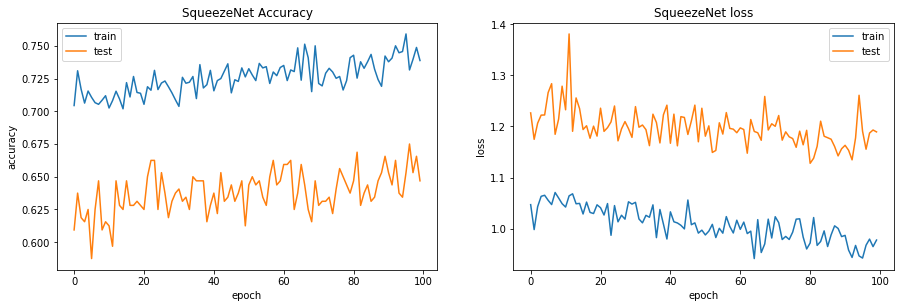

In [18]:
plot_accuracy_and_loss(history)

In [19]:
# Backup - Save model weights manually
#model_json = model.to_json()
#open('final_project_table2_model.json', 'w').write(model_json)

# Saving the model in h5 file format
model.save('final_project_table2_model.h5')

# save model's learned weights
model.save_weights('final_project_table2_weights.h5', overwrite=True)

In [20]:
# I used the functions defined here https://github.com/grishasergei/conviz
# Just to get nbr of rows and columns to better represent the matplot subfigures
def prime_powers(n):
    """
    Compute the factors of a positive integer
    Algorithm from https://rosettacode.org/wiki/Factors_of_an_integer#Python
    :param n: int
    :return: set
    """
    factors = set()
    for x in range(1, int(math.sqrt(n)) + 1):
        if n % x == 0:
            factors.add(int(x))
            factors.add(int(n // x))
    return sorted(factors)

def get_grid_dim(x):
    """
    Transforms x into product of two integers
    :param x: int
    :return: two ints
    """
    factors = prime_powers(x)
    if len(factors) % 2 == 0:
        i = int(len(factors) / 2)
        return factors[i], factors[i - 1]

    i = len(factors) // 2
    return factors[i], factors[i]


In [21]:
def filter_visualisation(name='conv1-conv'):
    #single_filter = filters[0]['wc5']
    
    single_filter = np.asarray(model.get_layer(name=name).get_weights())[0]
    
    print(single_filter.shape)
    
    # We know apriori that the filters are 3x3 matrices
    # The nbr of channels change from layer to layer
    channels = single_filter.shape[-2]
    # Get the nimber of conv filters at this layer
    num_filters = single_filter.shape[-1]
    # Create a figure
    fig, ax = plt.subplots(num_filters, channels)
    fig.set_size_inches(18, 12)
    #print(dir(fig))
    
    print('channels : {}, num_filters: {}'.format(channels, num_filters))
    
    for i in range(num_filters):
        for j in range(channels):
            #print('i: {}, j: {}'.format(i, j))
            ax[i][j].imshow(single_filter[:,:,j,i], interpolation='nearest', cmap='seismic')
            ax[i][j].axis('off')
    ax[0][channels//2].set_title('{} filters of layer: {}'.format(num_filters, name))
    plt.savefig(name+'_layer_filters.png', format='png', quality=95, pdi=1024)
    plt.show()
    
    

(3, 3, 3, 32)
channels : 3, num_filters: 32


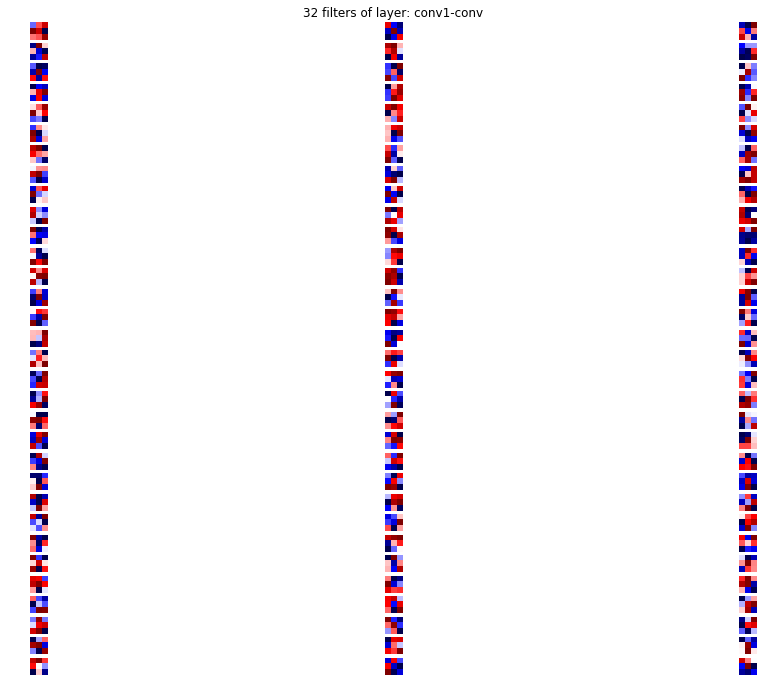

In [22]:
filter_visualisation(name='conv1-conv')
#filter_visualisation(name='conv11a')


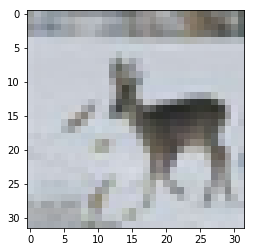

In [23]:
# Choose an image as input to see the featue maps developed for it
test_image = x_train[20:21]
plt.imshow(test_image[0])

In [24]:
'''
This function creates keras sub-model that ends at the layer of interest
Thus, the output of the sub-model is the feature maps at the layer of interest
It takes 3 parameters: 
    name: (string) name of the layer of interest
    test_img : (numpy array) image to feed the model with
    max_fmaps: (int) maximum number of feature maps to represent in the figure
output:
    displays a figure that contains max_fmaps feature maps at the layer of interest
'''
def fmap_vis(name='conv1-conv', test_img=None, max_fmaps=32):
    # Construct the sub-model that is used to visualize the intermediate layer
    intermediate_layer_model = Model(inputs = model.input,                      # both models should have the same inputs
                                    outputs = model.get_layer(name).output) # Last layer is the layer of interest !
    # Let's use the sub-model to see the feature maps at the layer of interest
    # matrix here represents the intermediate layer output
    intermediate_output = intermediate_layer_model.predict(test_image)[0]
    
    print(intermediate_output.shape)
    
    # Number of feature maps at the layer of interest
    maps_count = intermediate_output.shape[-1]
    # Limit the number of feature maps to the maximum user-defined choice (default = 32)
    if maps_count > max_fmaps:
        maps_count = max_fmaps

    # Get the number of rows and columns of the figure to show
    rows, columns = get_grid_dim(maps_count)
    print('Rows: {}, Columns: {}'.format(rows, columns))

    # Let's use matplotlib to visualize these feature maps
    # Create a figure
    fig, ax = plt.subplots(rows, columns)
    fig.set_size_inches(18, 12)
    c = 0
    for i in range(rows):
        for j in range(columns):
            #print('i: {}, j: {}'.format(i, j))
            ax[i][j].imshow(intermediate_output[:,:,c], interpolation='nearest')
            ax[i][j].axis('off')
            c+=1
    ax[0][columns//2].set_title('Feature maps of layer: {}'.format(name))
    # The feature maps figure will be saved in a png file
    plt.savefig(name+'_layer_feature_maps.png', format='png', quality=95, pdi=1024)
    plt.show()
    
    

(32, 32, 32)
Rows: 8, Columns: 4


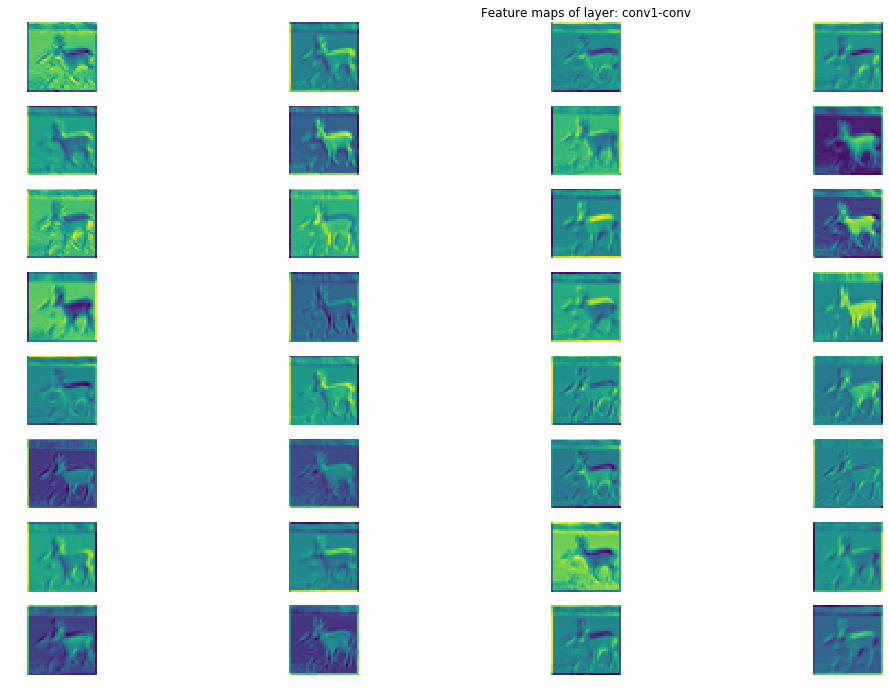

In [25]:
fmap_vis(name='conv1-conv', test_img=test_image, max_fmaps=32)

(4, 4, 256)
Rows: 8, Columns: 4


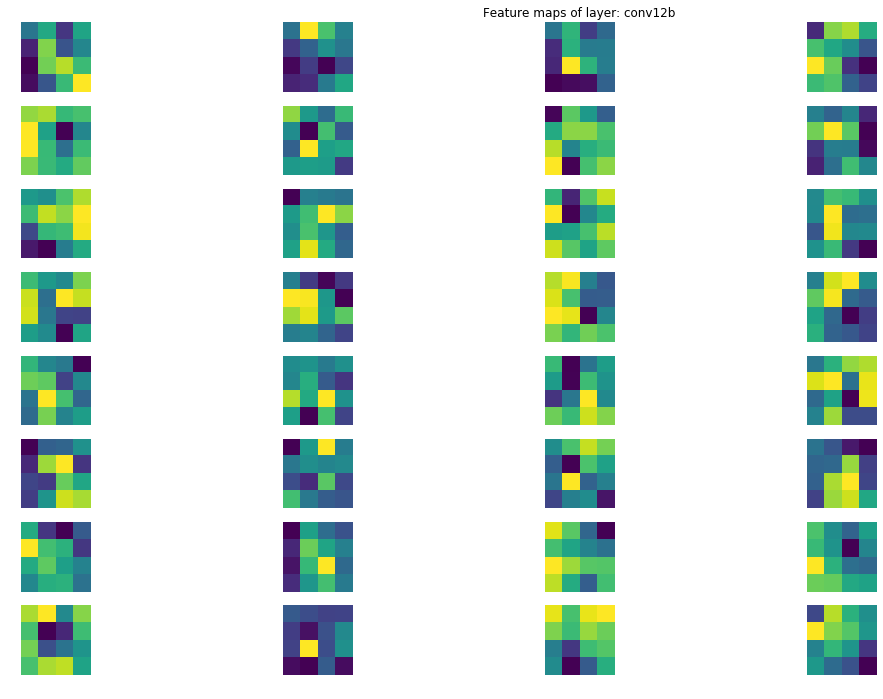

In [26]:
fmap_vis(name='conv12b', test_img=test_image, max_fmaps=32)

(4, 4, 256)
Rows: 8, Columns: 4


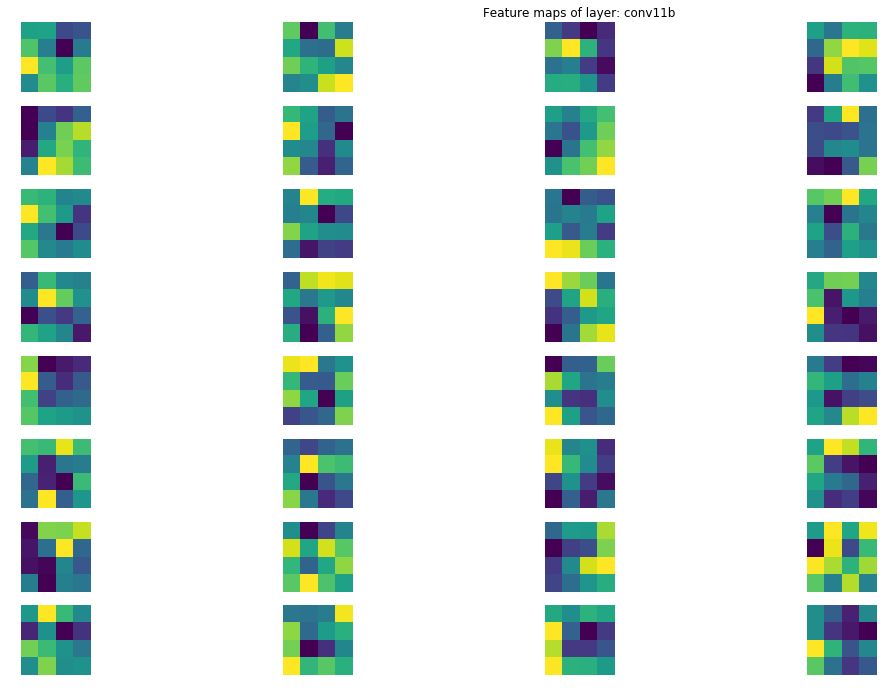

In [27]:
fmap_vis(name='conv11b', test_img=test_image, max_fmaps=32)